<a href="https://colab.research.google.com/github/InbumS/DreamscomeTrue/blob/main/swimTransfomer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

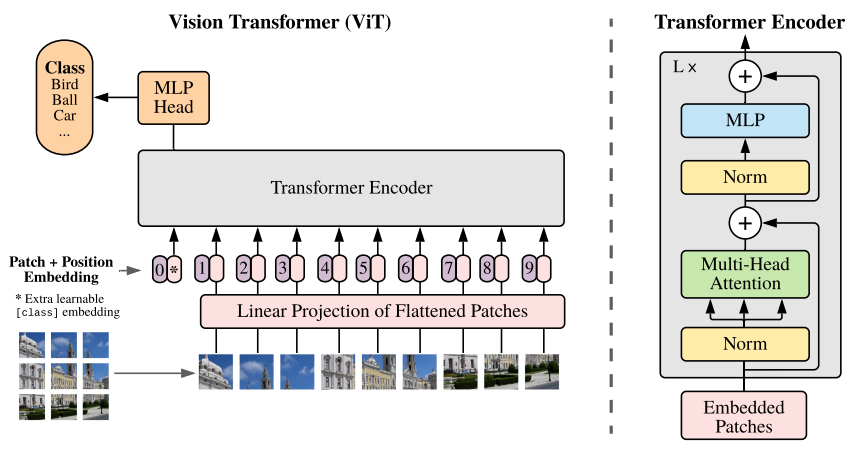

cnn은 지역적이다. -> transfomer연구가 진행

### Background: VIT(visual transfomer)모델보다 더 적은 연산량을 요구하는 모델

* 이미지도 텍스트처럼 sequence구조 사용. 

* patch는 token과 유사한 형태 (nlp or CV).

* H X W X C -> N X (P X P X C)  * N: 시퀀스 수, P X P: 이미지를 나누는 고정된 patch 크기

Self Attention: 입력 값을 Query, Key, Value로 만들어주고 Q, K 내적 후 정규화한 Chead를 나눈후 softmax activation 후 V와 내적

그러나 pre-training작업을 많이 해줘야 성능이 나온다, 어텐션 성능 또한 굿


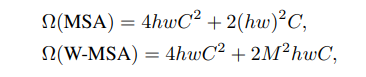

Window size를 나누며 계산량을 줄일 수 있다.

# Swin Transformer

https://arxiv.org/abs/2103.14030

* VIT모델을 더 작은 local window에 적용시켜 이미지의 변동에도 성능을 입증시키자 

* window사이즈에 각각 attention을 적용한다.
* local window를 모델에 적용

H X W X C = 32 X 32 X 3 

M: local window 크기 = 4
n: local window 개수 = 4
N: patch개수 = 64
Ph,Pw : patch크기 = 4


Model 구조

* patch merging => 차원 축소 및 flatten과정을 거쳐 해상도를 줄임
* Swin Transfomer Block 
W-MSA :Local Window안에서의 self attention
SW-NSA : Local Window간의 self attention

Efficient batch computation
patch들을 window사이즈를 배치와 같은 차원으로 나누어 for문 같은 반복을 줄이고 병렬처리로 계산

Swin Transfomer Block
* 두 축마다 relative poisition의 범위 [-M+1,M-1]

Relative Position Bias
window크기의 매트리스와 index차이를 구한다.
최소 0 최대 24의 거리가 나옴

SW-MSA
수행시 window 개수가 증가 -> 비효율적 padding또한 값이 너무 많이 듬.
* 해결책: Cyclic shift(원형 이동) & Attention mask  -> window 갯수 동일
* 인접한 부분이 아닌 곳은 mask적용 and 개별적으로 attention

attention mask + query화된 내적값


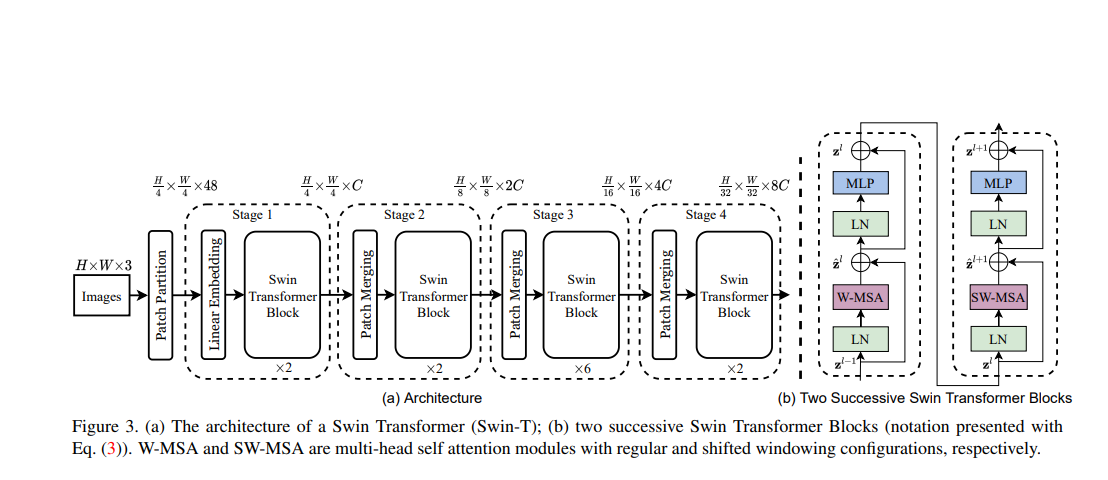


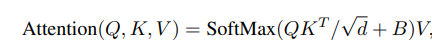

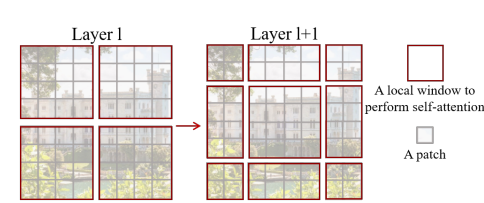

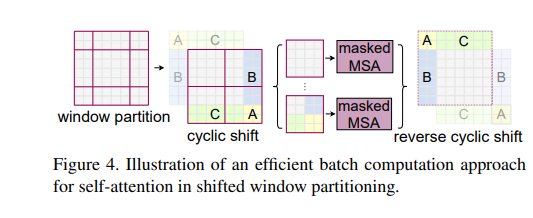

다양한 augmentation과 regulazation필요

cnn based model vs Swin
ex)efficient net

* 성능과 학습속도의 trade off가 더 작음.
* VIT 대비 적은 파라미터로 높은 성능

Object Detection 부분에서 Resnet-50 대비 성능이 +3.4~4.2 Box AP를 보여줌

Result:
* Local window를 적용해 inductive bias를 줄인다.
* patch merging을 통해 Hierarchial 구조 형성

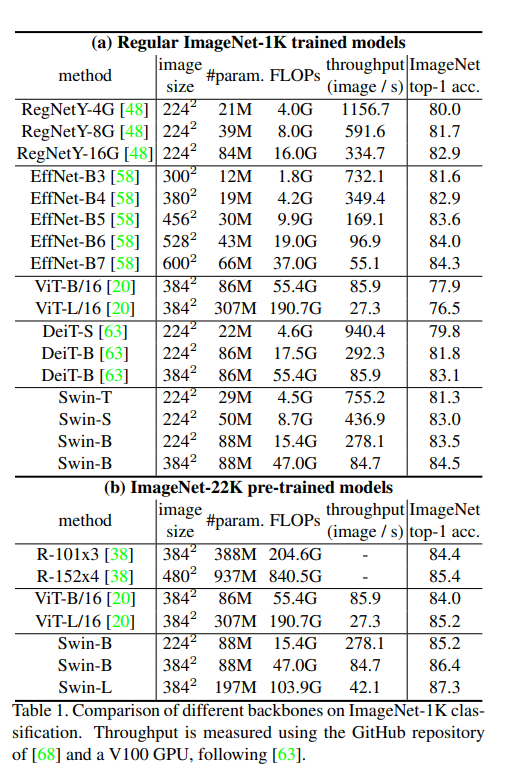


In [ ]:
class SwinTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, **kwargs):
        super().__init__()
		
        # ...
        
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
            
        # ...

        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint)
            self.layers.append(layer)
        
        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
		
        # ...
    
    # ...

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)  # B L C
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x
	
    # ...

In [ ]:
class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding
    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    # ...

In [ ]:
class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        # ...
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        # ...

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    # ...

In [ ]:
def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows